In [ ]:
# import requirements
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import save_model

print('TensorFlow version: ', tf.__version__)

TensorFlow version:  2.18.0


# Transfer Learning

## Downloading Data

In [ ]:
# download dataset
path = '/content/garbage_classification_train_test.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

## Train, Test and Validation Sets

In [ ]:
# select train & test datasets
train_dir = 'garbage_classification_train_test/train_set'
test_dir = 'garbage_classification_train_test/test_set'

In [ ]:
# set sizes
img_size = (224,224)
batch_size = 32

In [ ]:
# TRAIN DATA : data augmentation done to prevent overfitting
training_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    horizontal_flip = True,
    zoom_range = 0.1,
    validation_split = 0.2)

In [ ]:
# prepare train dataset
train_dataset = training_generator.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

Found 1617 images belonging to 6 classes.


In [ ]:
# check classes
print(train_dataset.classes)
print(train_dataset.class_indices)

[0 0 0 ... 5 5 5]
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


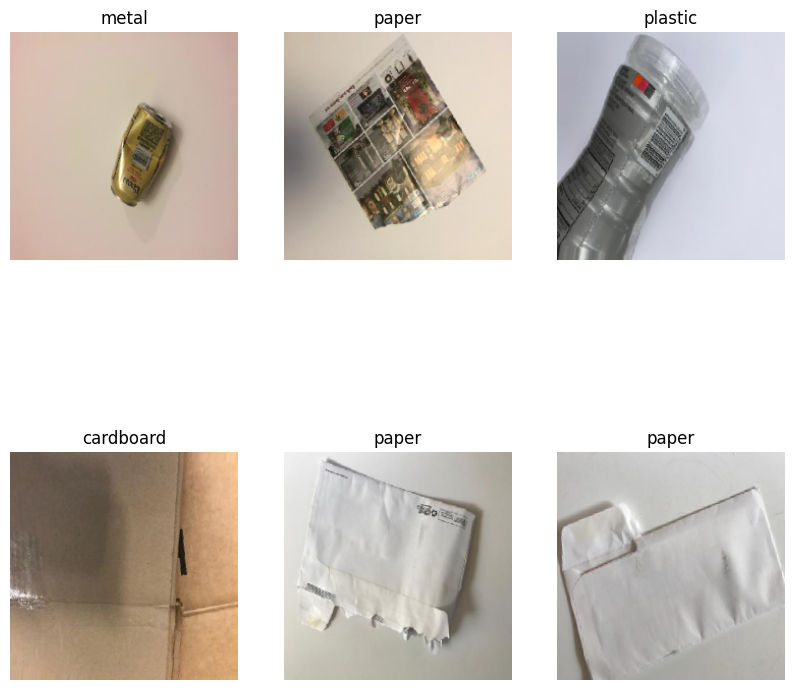

In [ ]:
# show first 6 images of a batch
class_names = list(train_dataset.class_indices.keys())
images, labels = next(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    class_index = np.argmax(labels[i])
    plt.title(class_names[class_index])
    plt.axis("off")
plt.show()

In [ ]:
# VALIDATION DATA : prepare validation dataset from train dataset
validation_dataset = training_generator.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 402 images belonging to 6 classes.


In [ ]:
# TEST DATA : no data augmentation done, only rescaling
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
# prepare test dataset
test_dataset = test_generator.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

Found 508 images belonging to 6 classes.


## Loading Pre-trained MobileNetV2

In [ ]:
# select pre-trained model MobileNetV2 trained on the dataset ImageNet
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet')

In [ ]:
# show summary of base model
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# show number of layers
len(base_model.layers)

154

## Freezing Layers

In [ ]:
# keep the pre-trained weights of base model fixed
for layer in base_model.layers:
  layer.trainable = False

for layer in base_model.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<Conv2D name=Conv1, built=True> False
<BatchNormalization name=bn_Conv1, built=True> False
<ReLU name=Conv1_relu, built=True> False
<DepthwiseConv2D name=expanded_conv_depthwise, built=True> False
<BatchNormalization name=expanded_conv_depthwise_BN, built=True> False
<ReLU name=expanded_conv_depthwise_relu, built=True> False
<Conv2D name=expanded_conv_project, built=True> False
<BatchNormalization name=expanded_conv_project_BN, built=True> False
<Conv2D name=block_1_expand, built=True> False
<BatchNormalization name=block_1_expand_BN, built=True> False
<ReLU name=block_1_expand_relu, built=True> False
<ZeroPadding2D name=block_1_pad, built=True> False
<DepthwiseConv2D name=block_1_depthwise, built=True> False
<BatchNormalization name=block_1_depthwise_BN, built=True> False
<ReLU name=block_1_depthwise_relu, built=True> False
<Conv2D name=block_1_project, built=True> False
<BatchNormalization name=block_1_project_BN, built=True> False
<Con

In [ ]:
# show expected output of base model
base_model.output

<KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_153>

## Custom Dense Layer

In [ ]:
# NEW DENSE LAYERS : add custom head on top of the base model to build new model
# NOTE : number of dense layers added & neurons used were recommendations by ChatGPT
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)                 # reduce spatial dimensions of output from base model to a single value
head_model = Dense(units = 512, activation='relu')(head_model)    # add dense layer 1
head_model = Dropout(rate = 0.3)(head_model)
head_model = Dense(units = 256, activation='relu')(head_model)    # add dense layer 2
head_model = Dropout(rate = 0.3)(head_model)
head_model = Dense(6, activation='softmax')(head_model)

## Building and Training Neural Network

In [ ]:
# show expected input of base model
base_model.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>

In [ ]:
# build new model
new_model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
# show summary of new model
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,046,726 (11.62 MB)

 Trainable params: 788,742 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# show number of layers
len(new_model.layers)

160

In [ ]:
# compile new model
new_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# set up early stop for training new model
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

In [ ]:
# train new model
history = new_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 10,
    callbacks = [early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.4986 - loss: 1.3689

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 48s 720ms/step - accuracy: 0.5005 - loss: 1.3635 - val_accuracy: 0.6517 - val_loss: 0.8482
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 484ms/step - accuracy: 0.7527 - loss: 0.6754 - val_accuracy: 0.6915 - val_loss: 0.7911
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 474ms/step - accuracy: 0.8188 - loss: 0.5017 - val_accuracy: 0.6816 - val_loss: 0.8324
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 471ms/step - accuracy: 0.8461 - loss: 0.4354 - val_accuracy: 0.7388 - val_loss: 0.7133
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 570ms/step - accuracy: 0.8872 - loss: 0.3557 - val_accuracy: 0.7214 - val_loss: 0.8693
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 467ms/step - accuracy: 0.8998 - loss: 0.2675 - val_accuracy: 0.7289 - val_loss: 0.8024
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 476ms/step - accuracy: 0.9291 - loss: 0.2025 - val_accuracy: 0.7189 - val_loss: 0.8808


## Predictions

In [ ]:
# check classes
print(test_dataset.classes)
print(test_dataset.class_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5
 5 5 5 5 5 5 5 5 5 5 5 5 

In [ ]:
# predict class probabilities on test dataset using new model
predictions = new_model.predict(test_dataset)
predictions = np.argmax(predictions, axis = 1)
predictions

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step


array([0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 4,
       1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 3,
       4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 3,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 4, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       4, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 0, 3, 0, 3, 2, 3, 3, 3, 3, 3, 3,

In [ ]:
# show classes on test dataset
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

## Model Evaluation

In [ ]:
# check accuracy
accuracy_score(test_dataset.classes, predictions)

0.8248031496062992

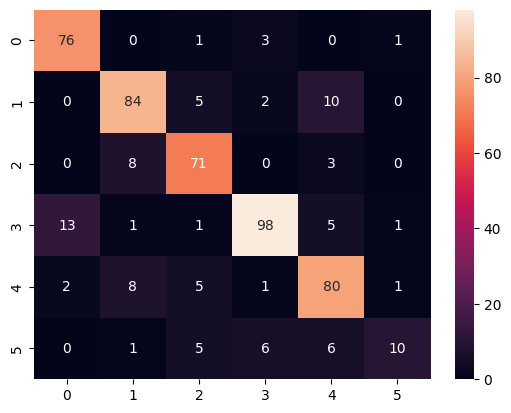

In [ ]:
# display confusion matrix
conf_matrix = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(conf_matrix, annot = True);

In [ ]:
# display classification report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88        81
           1       0.82      0.83      0.83       101
           2       0.81      0.87      0.84        82
           3       0.89      0.82      0.86       119
           4       0.77      0.82      0.80        97
           5       0.77      0.36      0.49        28

    accuracy                           0.82       508
   macro avg       0.82      0.77      0.78       508
weighted avg       0.83      0.82      0.82       508



# Fine-Tuning

In [ ]:
# prepare base model for fine tuning
base_model.trainable = True
for layer in base_model.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<Conv2D name=Conv1, built=True> False
<BatchNormalization name=bn_Conv1, built=True> False
<ReLU name=Conv1_relu, built=True> False
<DepthwiseConv2D name=expanded_conv_depthwise, built=True> False
<BatchNormalization name=expanded_conv_depthwise_BN, built=True> False
<ReLU name=expanded_conv_depthwise_relu, built=True> False
<Conv2D name=expanded_conv_project, built=True> False
<BatchNormalization name=expanded_conv_project_BN, built=True> False
<Conv2D name=block_1_expand, built=True> False
<BatchNormalization name=block_1_expand_BN, built=True> False
<ReLU name=block_1_expand_relu, built=True> False
<ZeroPadding2D name=block_1_pad, built=True> False
<DepthwiseConv2D name=block_1_depthwise, built=True> False
<BatchNormalization name=block_1_depthwise_BN, built=True> False
<ReLU name=block_1_depthwise_relu, built=True> False
<Conv2D name=block_1_project, built=True> False
<BatchNormalization name=block_1_project_BN, built=True> False
<Con

In [ ]:
# compare number of layers for base and new models
print(len(base_model.layers))
print(len(new_model.layers))

154
160


In [ ]:
# fine tune portion of base model layers (last 30 layers)
fine_tuning_at = 124
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [ ]:
# compile fine-tuned model
new_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# train fine-tuned model
history = new_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 10,
    callbacks = [early_stop]
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 656ms/step - accuracy: 0.8488 - loss: 0.4090 - val_accuracy: 0.7587 - val_loss: 0.7904
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 479ms/step - accuracy: 0.8833 - loss: 0.3110 - val_accuracy: 0.7214 - val_loss: 0.8711
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 503ms/step - accuracy: 0.8988 - loss: 0.2955 - val_accuracy: 0.7463 - val_loss: 0.8130
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 480ms/step - accuracy: 0.9235 - loss: 0.2103 - val_accuracy: 0.7214 - val_loss: 0.8791


In [ ]:
# predict class probabilities on test dataset using fine-tuned model
predictions = new_model.predict(test_dataset)
predictions = np.argmax(predictions, axis = 1)
predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step


array([0, 0, 0, 2, 0, 0, 3, 4, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 2,
       3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 1, 1, 1, 4,
       1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 3,
       4, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 2, 1, 4, 2, 1, 1, 2, 1, 3,
       4, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1,
       4, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 4, 1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 4, 2, 4, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       4, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 3, 0, 3, 3, 5, 3, 4, 3, 3, 3,

In [ ]:
# check accuracy
accuracy_score(test_dataset.classes, predictions)

0.8169291338582677

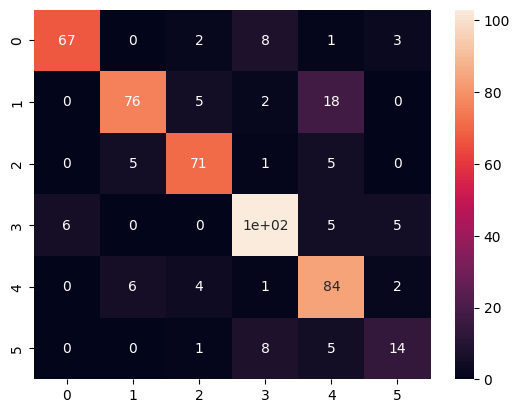

In [ ]:
# display new confusion matrix
conf_matrix = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(conf_matrix, annot = True);

In [ ]:
# display new classification report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87        81
           1       0.87      0.75      0.81       101
           2       0.86      0.87      0.86        82
           3       0.84      0.87      0.85       119
           4       0.71      0.87      0.78        97
           5       0.58      0.50      0.54        28

    accuracy                           0.82       508
   macro avg       0.80      0.78      0.79       508
weighted avg       0.82      0.82      0.82       508



In [ ]:
# save fine-tuned model
model_json = new_model.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

saved_model = save_model(new_model, '/content/weights.hdf5')